Expected vs Predicted:
Expected=A, Predicted=A
Expected=A, Predicted=A
Expected=A, Predicted=A
Expected=A, Predicted=A
Expected=A, Predicted=A
Expected=B, Predicted=B
Expected=B, Predicted=B
Expected=B, Predicted=B
Expected=B, Predicted=B
Expected=B, Predicted=B
Expected=A, Predicted=A
Expected=B, Predicted=B


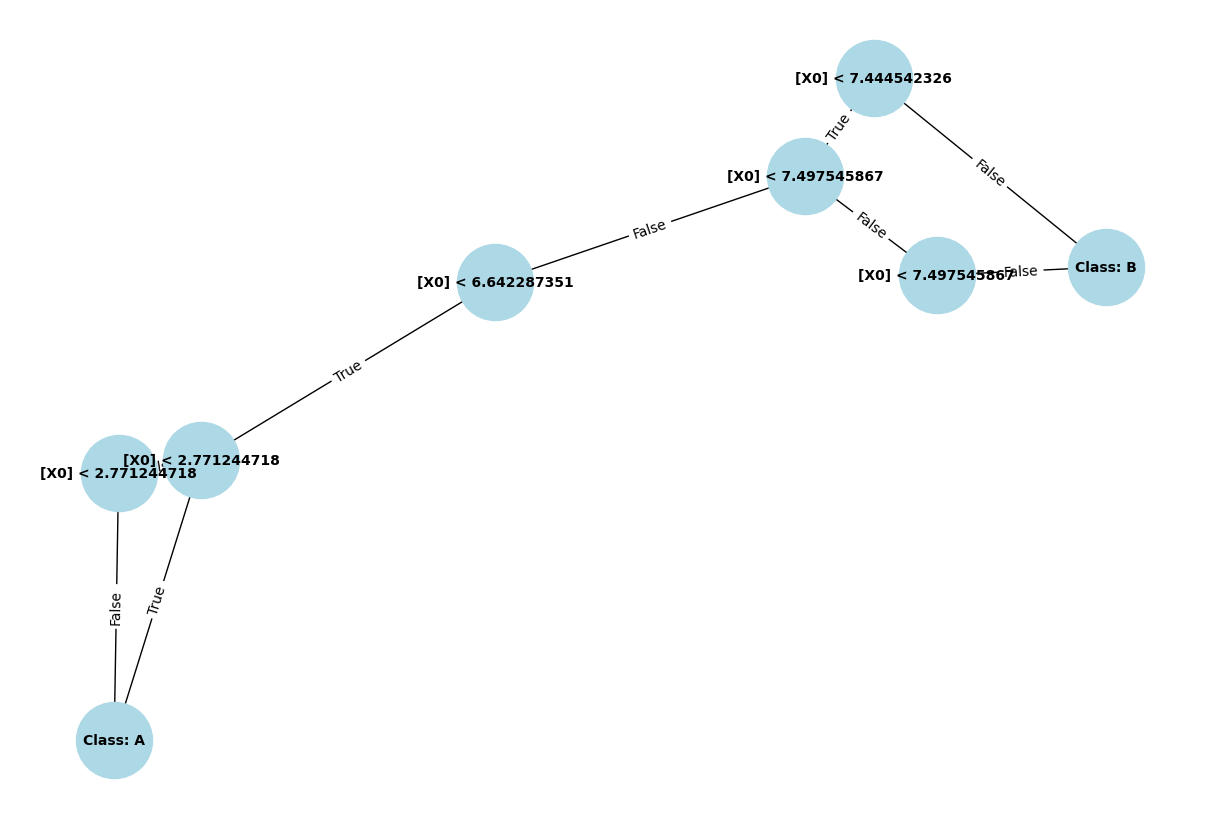

In [2]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import networkx as nx

def gini_impurity(groups, classes):
    n_instances = float(sum([len(group) for group in groups]))
    gini = 0.0
    for group in groups:
        size = float(len(group))
        if size == 0:
            continue
        score = 0.0
        for class_val in classes:
            proportion = [row[-1] for row in group].count(class_val) / size
            score += proportion * proportion
        gini += (1.0 - score) * (size / n_instances)
    return gini

def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if isinstance(value, str):
            if row[index] == value:
                left.append(row)
            else:
                right.append(row)
        else:
            if row[index] < value:
                left.append(row)
            else:
                right.append(row)
    return left, right

def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    best_index, best_value, best_score, best_groups = 999, 999, 999, None
    for index in range(len(dataset[0]) - 1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_impurity(groups, class_values)
            if gini < best_score:
                best_index, best_value, best_score, best_groups = index, row[index], gini, groups
    return {'index': best_index, 'value': best_value, 'groups': best_groups}

def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return Counter(outcomes).most_common(1)[0][0]

def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

def predict(node, row):
    if isinstance(node['value'], str):
        if row[node['index']] == node['value']:
            if isinstance(node['left'], dict):
                return predict(node['left'], row)
            else:
                return node['left']
        else:
            if isinstance(node['right'], dict):
                return predict(node['right'], row)
            else:
                return node['right']
    else:
        if row[node['index']] < node['value']:
            if isinstance(node['left'], dict):
                return predict(node['left'], row)
            else:
                return node['left']
        else:
            if isinstance(node['right'], dict):
                return predict(node['right'], row)
            else:
                return node['right']

def add_edges(graph, node, parent=None, edge_label=''):
    if isinstance(node, dict):
        node_label = f"[X{node['index']}] < {node['value']}" if not isinstance(node['value'], str) else f"[X{node['index']}] == {node['value']}"
        node_name = f"node_{id(node)}"
        graph.add_node(node_name, label=node_label)
        if parent:
            graph.add_edge(parent, node_name, label=edge_label)
        add_edges(graph, node['left'], parent=node_name, edge_label='True')
        add_edges(graph, node['right'], parent=node_name, edge_label='False')
    else:
        node_name = f"leaf_{id(node)}"
        graph.add_node(node_name, label=f"Class: {node}")
        if parent:
            graph.add_edge(parent, node_name, label=edge_label)

def draw_decision_tree(tree):
    graph = nx.DiGraph()
    add_edges(graph, tree)
    pos = nx.spring_layout(graph, seed=42)
    labels = nx.get_node_attributes(graph, 'label')
    edge_labels = nx.get_edge_attributes(graph, 'label')
    plt.figure(figsize=(12, 8))
    nx.draw(graph, pos, with_labels=True, labels=labels, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", arrows=False)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    plt.show()

dataset = [
    [2.771244718, 1.784783929, 'A'],
    [1.728571309, 1.169761413, 'A'],
    [3.678319846, 2.81281357, 'A'],
    [3.961043357, 2.61995032, 'A'],
    [2.999208922, 2.209014212, 'A'],
    [7.497545867, 3.162953546, 'B'],
    [9.00220326, 3.339047188, 'B'],
    [7.444542326, 0.476683375, 'B'],
    [10.12493903, 3.234550982, 'B'],
    [6.642287351, 3.319983761, 'B'],
    [5.0, 2.5, 'A'],
    [8.0, 2.5, 'B']
]

tree = build_tree(dataset, max_depth=3, min_size=1)

print("Expected vs Predicted:")
for row in dataset:
    prediction = predict(tree, row)
    print(f"Expected={row[-1]}, Predicted={prediction}")

draw_decision_tree(tree)
